# Hyperelastic Constitutive Law ML Pipeline

Complete pipeline for training neural networks on comprehensive hyperelastic material data.

This notebook uses a comprehensive dataset with 1,308 cases covering 11 different strain types:
- Uniaxial tension/compression
- Biaxial equal/unequal loading
- Pure and simple shear
- Planar tension
- Combined tension-shear
- Cyclic tension
- Complex multiaxial
- Random proportional loading

## Setup

In [71]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)

%matplotlib inline

## Data Loading

In [72]:
from data.loader import DataLoader

# Load dataset
data_path = "../../neohookean-dataset-generator/hyperelastic_comprehensive_experiments"
loader = DataLoader(data_path)
dataset = loader.load_dataset()

print(f"Dataset loaded: {dataset['n_samples']} samples, {dataset['n_cases']} cases")
print(f"Strain components: {list(dataset['strain_components'])}")
print(f"Stress components: {list(dataset['stress_components'])}")

Loading ML-ready dataset: ../../neohookean-dataset-generator/hyperelastic_comprehensive_experiments/ml_ready_dataset.npz
Dataset loaded: 65400 samples, 1308 cases
Strain components: [np.str_('Exx'), np.str_('Eyy'), np.str_('Exy')]
Stress components: [np.str_('Sxx'), np.str_('Syy'), np.str_('Sxy')]


## Data Exploration

In [73]:
# Convert to DataFrame for easier analysis
df = loader.to_dataframe(dataset)
print(f"DataFrame shape: {df.shape}")

# Show strain type distribution if available
if 'strain_type' in df.columns:
    print(f"\nStrain types in dataset:")
    strain_dist = df['strain_type'].value_counts()
    for strain_type, count in strain_dist.items():
        print(f"  {strain_type}: {count:,} data points")
    print(f"\nTotal strain types: {len(strain_dist)}")

df.head()

DataFrame shape: (65400, 8)

Strain types in dataset:
  random_proportional: 11,400 data points
  complex_multiaxial: 5,400 data points
  combined_tension_shear: 5,400 data points
  cyclic_tension: 5,400 data points
  pure_shear: 5,400 data points
  planar_tension: 5,400 data points
  uniaxial_tension: 5,400 data points
  uniaxial_compression: 5,400 data points
  simple_shear: 5,400 data points
  biaxial_unequal: 5,400 data points
  biaxial_equal: 5,400 data points

Total strain types: 11


,strain_exx,strain_eyy,strain_exy,stress_sxx,stress_syy,stress_sxy,case_number,strain_type
0,0.0,-0.0,-0.0,0.0,0.0,0.0,1,random_proportional
1,0.0007779927805930833,-0.00397252043755355,-0.0006764756158614449,9956.564237627985,-51344.42749576873,-4364.646958286514,1,random_proportional
2,0.0015559855611861665,-0.0079450408751071,-0.0013529512317228898,19876.276564982185,-103523.97430804341,-8786.130768767183,1,random_proportional
3,0.00233397834177925,-0.011917561312660651,-0.002029426847584335,29759.190437743564,-156559.15284173537,-13265.915726200525,1,random_proportional
4,0.003111971122372333,-0.0158900817502142,-0.0027059024634457796,39605.35491433345,-210471.1530126723,-17805.514051216618,1,random_proportional


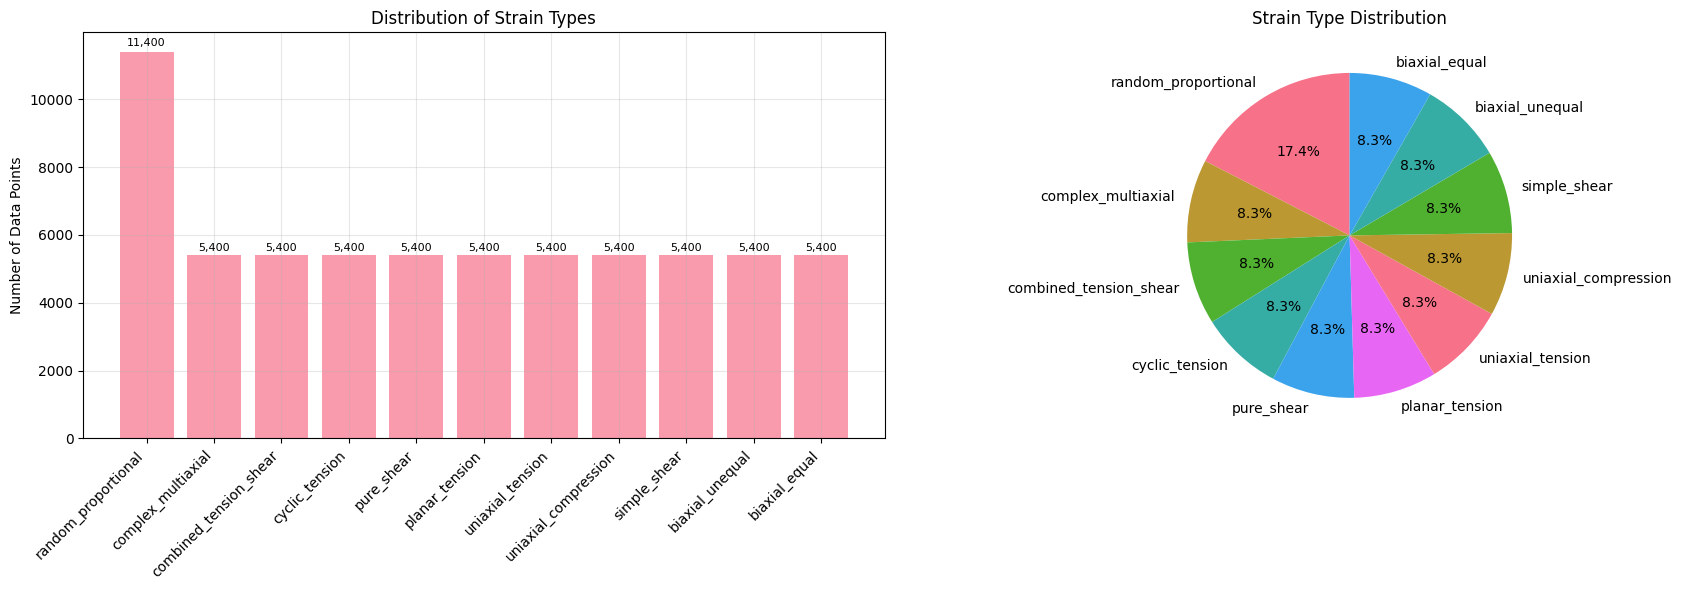


Dataset contains 11 different strain types
Total cases: 1,308


In [74]:
# Strain type distribution visualization
if 'strain_type' in df.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Bar plot of strain types
    strain_counts = df['strain_type'].value_counts()
    bars = ax1.bar(range(len(strain_counts)), strain_counts.values, alpha=0.7)
    ax1.set_xticks(range(len(strain_counts)))
    ax1.set_xticklabels(strain_counts.index, rotation=45, ha='right')
    ax1.set_ylabel('Number of Data Points')
    ax1.set_title('Distribution of Strain Types')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars, strain_counts.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{val:,}', ha='center', va='bottom', fontsize=8)
    
    # Pie chart
    ax2.pie(strain_counts.values, labels=strain_counts.index, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Strain Type Distribution')
    
    plt.tight_layout()
    plt.show()

print(f"\nDataset contains {len(df['strain_type'].unique() if 'strain_type' in df.columns else []):,} different strain types")
print(f"Total cases: {len(df['case_number'].unique() if 'case_number' in df.columns else []):,}")

In [75]:
# Basic statistics
df.describe()

,case_number
count,65400.000000
mean,654.500000
std,377.589852
min,1.000000
25%,327.750000
50%,654.500000
75%,981.250000
max,1308.000000


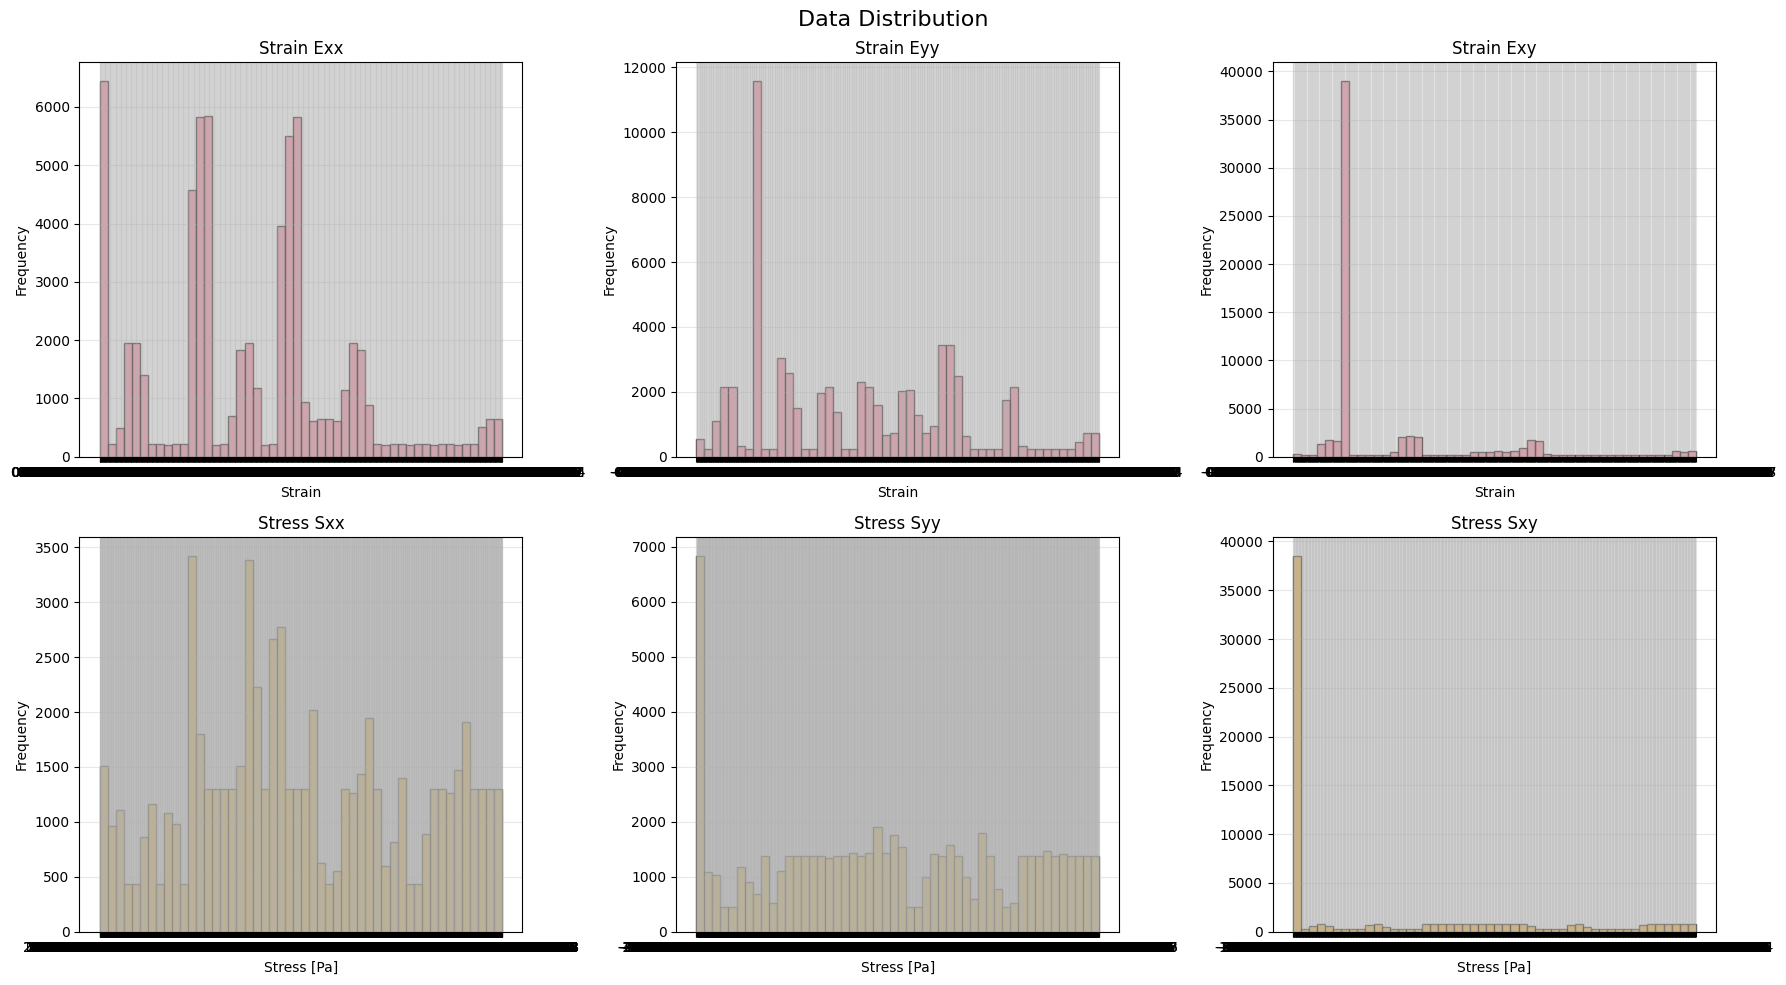

In [76]:
# Distribution plots
strain_cols = [col for col in df.columns if col.startswith('strain_') and col != 'strain_type']
stress_cols = [col for col in df.columns if col.startswith('stress_')]
n_components = len(strain_cols)

fig, axes = plt.subplots(2, n_components, figsize=(6*n_components, 10))

# Strain distributions
for i, col in enumerate(strain_cols):
    axes[0, i].hist(df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[0, i].set_title(f'{col.replace("_", " ").title()}')
    axes[0, i].set_xlabel('Strain')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].grid(True, alpha=0.3)

# Stress distributions
for i, col in enumerate(stress_cols):
    axes[1, i].hist(df[col], bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1, i].set_title(f'{col.replace("_", " ").title()}')
    axes[1, i].set_xlabel('Stress [Pa]')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].grid(True, alpha=0.3)

plt.suptitle('Data Distribution', fontsize=16)
plt.tight_layout()
plt.show()

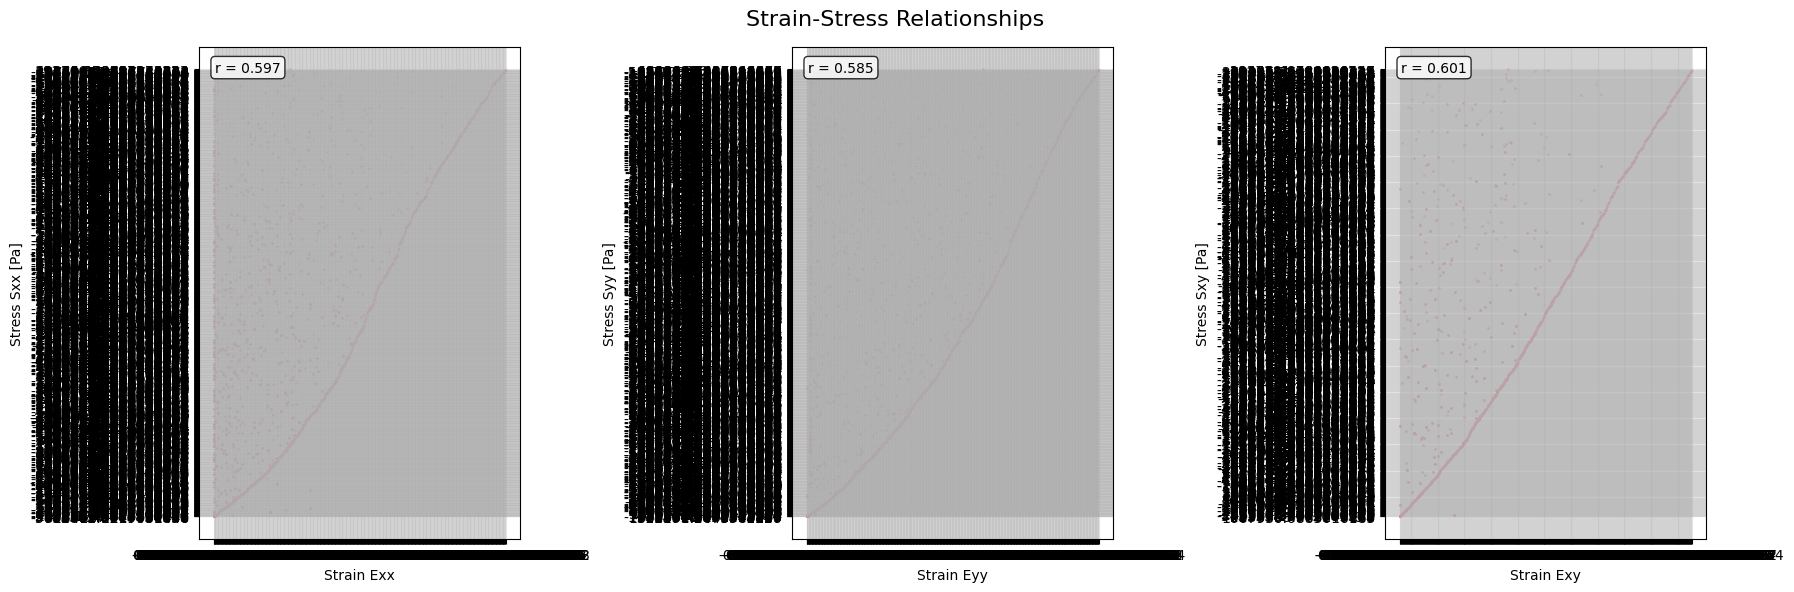

In [77]:
# Strain-stress relationships
fig, axes = plt.subplots(1, n_components, figsize=(6*n_components, 6))
if n_components == 1:
    axes = [axes]  # Make it iterable for single component

for i, (strain_col, stress_col) in enumerate(zip(strain_cols, stress_cols)):
    # Sample data for plotting (to avoid overplotting)
    sample_idx = np.random.choice(len(df), min(5000, len(df)), replace=False)
    df_sample = df.iloc[sample_idx]
    
    axes[i].scatter(df_sample[strain_col], df_sample[stress_col], alpha=0.4, s=1)
    axes[i].set_xlabel(strain_col.replace('_', ' ').title())
    axes[i].set_ylabel(stress_col.replace('_', ' ').title() + ' [Pa]')
    axes[i].grid(True, alpha=0.3)
    
    # Add correlation
    corr = df[strain_col].corr(df[stress_col])
    axes[i].text(0.05, 0.95, f'r = {corr:.3f}', 
                transform=axes[i].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Strain-Stress Relationships', fontsize=16)
plt.tight_layout()
plt.show()

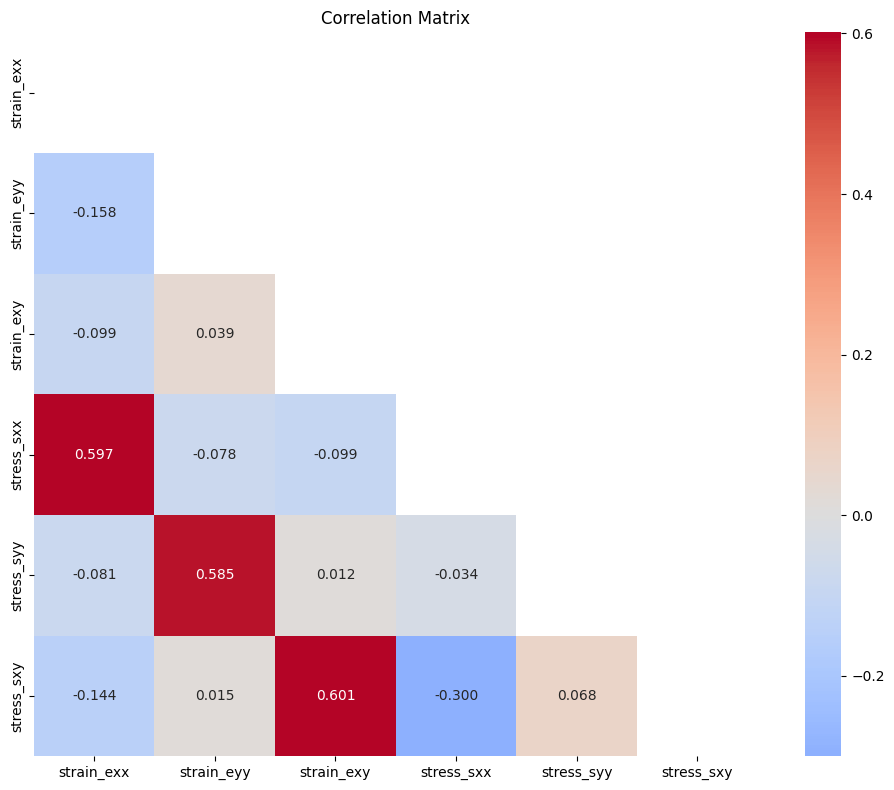

In [78]:
# Correlation matrix
# Only include numeric strain and stress columns
strain_cols_numeric = [col for col in df.columns if col.startswith('strain_') and col != 'strain_type']
stress_cols_numeric = [col for col in df.columns if col.startswith('stress_')]
feature_cols = strain_cols_numeric + stress_cols_numeric
corr_matrix = df[feature_cols].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.3f')

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [79]:
# 3D strain space visualization
from mpl_toolkits.mplot3d import Axes3D

if len(strain_cols) >= 3:
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Sample for 3D plot
    sample_idx = np.random.choice(len(df), min(2000, len(df)), replace=False)
    df_sample = df.iloc[sample_idx]
    
    # Use first three strain columns
    x_col, y_col, z_col = strain_cols[:3]
    
    # Convert case_number to numeric for coloring
    if 'case_number' in df_sample.columns:
        # Ensure case_number is numeric
        case_colors = pd.to_numeric(df_sample['case_number'], errors='coerce')
        # Fill any NaN values with 0
        case_colors = case_colors.fillna(0)
    else:
        # Use index as fallback
        case_colors = df_sample.index
    
    scatter = ax.scatter(df_sample[x_col], df_sample[y_col], 
                        df_sample[z_col], c=case_colors, 
                        cmap='viridis', alpha=0.6, s=20)
    
    ax.set_xlabel(x_col.replace('_', ' ').title())
    ax.set_ylabel(y_col.replace('_', ' ').title())
    ax.set_zlabel(z_col.replace('_', ' ').title())
    ax.set_title('3D Strain Space')
    
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
    cbar.set_label('Case Number')
    
    plt.show()
else:
    print(f'Need at least 3 strain components for 3D plot, found {len(strain_cols)}')

TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 1200x800 with 2 Axes>

## Advanced Visualizations

Detailed visualizations similar to those in the dataset generator, showing strain sphere, strain histories, and strain-stress relationships.

In [80]:
# Configure matplotlib for consistent formatting (matching dataset generator style)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

In [81]:
# Strain Sphere Visualization
# Create comprehensive 3D visualization showing all strain cases

# Define strain columns (excluding strain_type)
strain_cols = [col for col in df.columns if col.startswith('strain_') and col != 'strain_type']
stress_cols = [col for col in df.columns if col.startswith('stress_')]

if len(strain_cols) >= 3:
    fig = plt.figure(figsize=(15, 10))
    
    # Main strain sphere plot
    ax1 = fig.add_subplot(221, projection='3d')
    
    # Sample for better visualization
    sample_size = min(5000, len(df))
    sample_idx = np.random.choice(len(df), sample_size, replace=False)
    df_sample = df.iloc[sample_idx]
    
    # Use the first three strain components
    x_col, y_col, z_col = strain_cols[:3]
    
    scatter1 = ax1.scatter(df_sample[x_col], df_sample[y_col], df_sample[z_col], 
                          c='green', marker='o', alpha=0.6, s=15, label='Strain Cases')
    
    ax1.set_xlabel(r'$\varepsilon_{xx}$', fontsize=12)
    ax1.set_ylabel(r'$\varepsilon_{yy}$', fontsize=12)
    ax1.set_zlabel(r'$\gamma_{xy}$', fontsize=12)
    ax1.set_title('Strain Space Distribution', fontsize=14, fontweight='bold')
    ax1.legend()
    
    # Strain sphere colored by case number
    ax2 = fig.add_subplot(222, projection='3d')
    
    # Convert case_number to numeric for coloring
    if 'case_number' in df_sample.columns:
        case_colors = pd.to_numeric(df_sample['case_number'], errors='coerce').fillna(0)
    else:
        case_colors = df_sample.index
    
    scatter2 = ax2.scatter(df_sample[x_col], df_sample[y_col], df_sample[z_col], 
                          c=case_colors, cmap='viridis', alpha=0.7, s=15)
    
    ax2.set_xlabel(r'$\varepsilon_{xx}$', fontsize=12)
    ax2.set_ylabel(r'$\varepsilon_{yy}$', fontsize=12)
    ax2.set_zlabel(r'$\gamma_{xy}$', fontsize=12)
    ax2.set_title('Strain Space by Case Number', fontsize=14, fontweight='bold')
    
    cbar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.6)
    cbar2.set_label('Case Number', fontsize=10)
    
    # Strain space colored by strain type
    ax3 = fig.add_subplot(223, projection='3d')
    
    if 'strain_type' in df_sample.columns:
        # Create color map for strain types
        unique_types = df_sample['strain_type'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_types)))
        type_color_map = dict(zip(unique_types, colors))
        
        for strain_type in unique_types:
            mask = df_sample['strain_type'] == strain_type
            if mask.sum() > 0:
                ax3.scatter(df_sample[mask][x_col], df_sample[mask][y_col], 
                           df_sample[mask][z_col], c=[type_color_map[strain_type]], 
                           alpha=0.7, s=15, label=strain_type)
        
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        scatter3 = ax3.scatter(df_sample[x_col], df_sample[y_col], df_sample[z_col], 
                              c='blue', alpha=0.7, s=15)
    
    ax3.set_xlabel(r'$\varepsilon_{xx}$', fontsize=12)
    ax3.set_ylabel(r'$\varepsilon_{yy}$', fontsize=12)
    ax3.set_zlabel(r'$\gamma_{xy}$', fontsize=12)
    ax3.set_title('Strain Space by Strain Type', fontsize=14, fontweight='bold')
    
    # Strain magnitude distribution
    ax4 = fig.add_subplot(224)
    
    # Calculate strain magnitude (Frobenius norm)
    strain_magnitude = np.sqrt(df_sample[strain_cols[0]]**2 + 
                              df_sample[strain_cols[1]]**2 + 
                              df_sample[strain_cols[2]]**2)
    
    ax4.hist(strain_magnitude, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax4.set_xlabel('Strain Magnitude [-]', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('Distribution of Strain Magnitudes', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Comprehensive Strain Space Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

else:
    print(f'Need at least 3 strain components for strain sphere visualization, found {len(strain_cols)}')

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'int'

Error in callback <function _draw_all_if_interactive at 0x117d7f240> (for post_execute), with arguments args (),kwargs {}:


TypeError: can't multiply sequence by non-int of type 'float'

TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 1500x1000 with 5 Axes>

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'int'

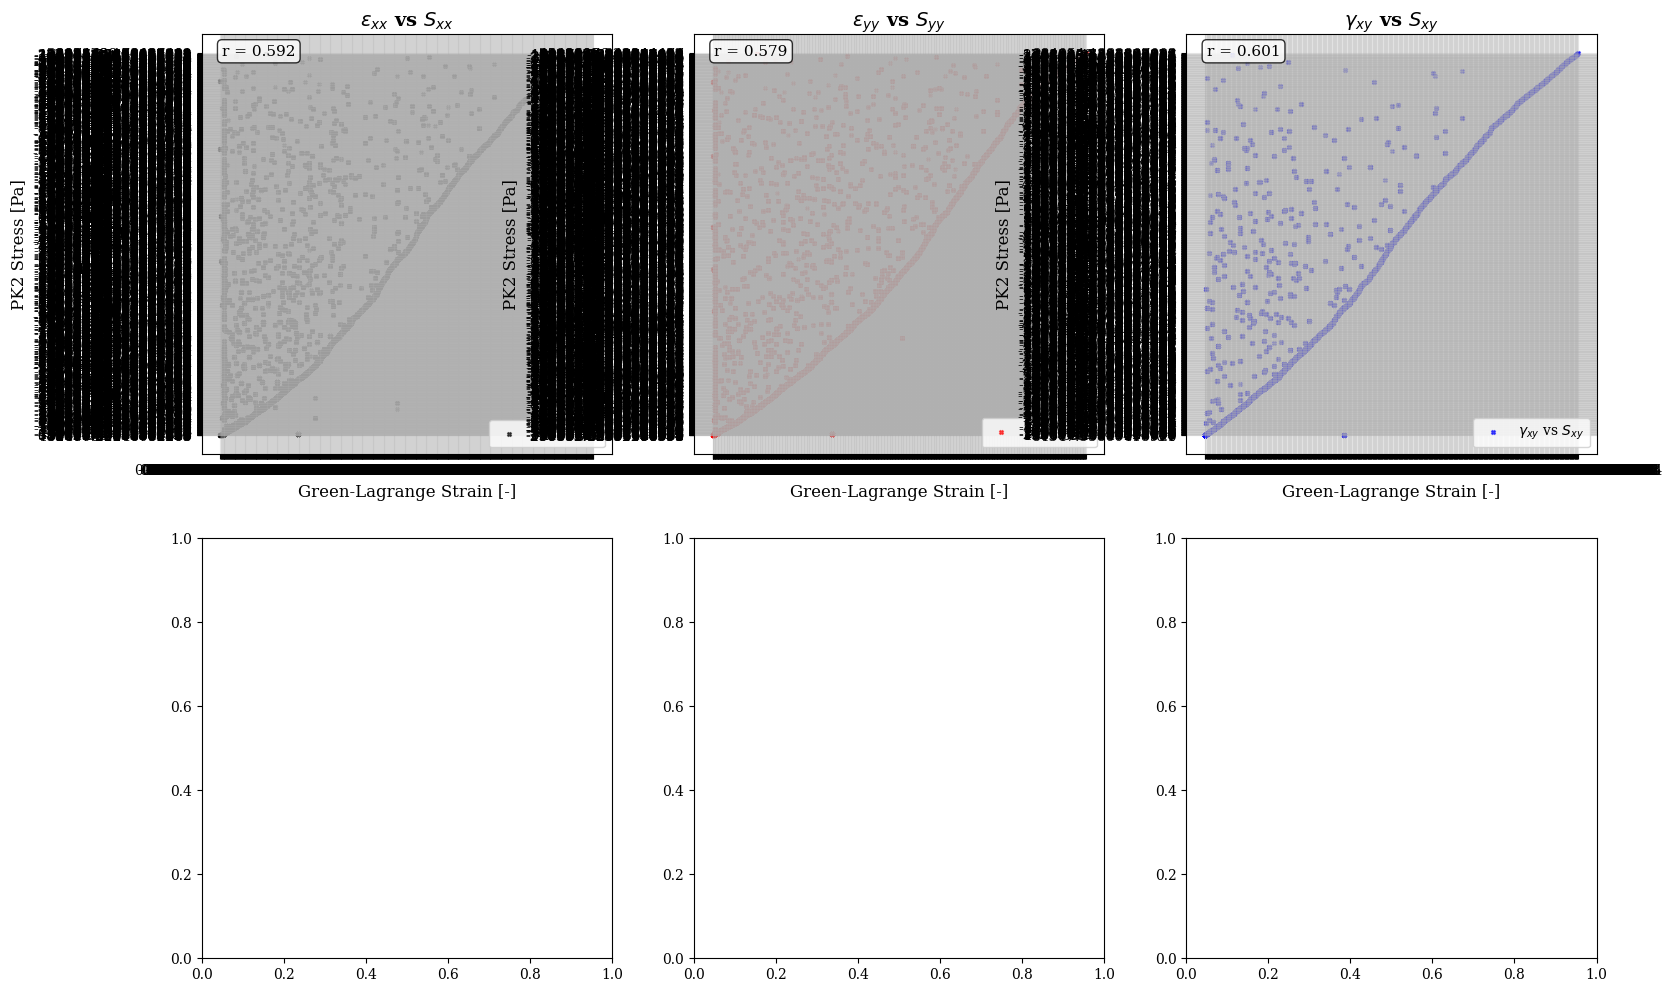

In [82]:
# Detailed Strain-Stress Relationship Analysis
# Create comprehensive strain-stress plots matching dataset generator style

# Define strain and stress columns (in case not already defined)
if 'strain_cols' not in locals():
    strain_cols = [col for col in df.columns if col.startswith('strain_') and col != 'strain_type']
    stress_cols = [col for col in df.columns if col.startswith('stress_')]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Sample data for better visualization
sample_size = min(8000, len(df))
sample_idx = np.random.choice(len(df), sample_size, replace=False)
df_sample = df.iloc[sample_idx]

# Plot each strain-stress relationship
for i, (strain_col, stress_col) in enumerate(zip(strain_cols, stress_cols)):
    ax = axes[i]
    
    # Create scatter plot with styling similar to dataset generator
    colors = ['k', 'r', 'b']
    markers = ['X', 'X', 'X']
    labels = [r'$\varepsilon_{xx}$ vs $S_{xx}$', r'$\varepsilon_{yy}$ vs $S_{yy}$', r'$\gamma_{xy}$ vs $S_{xy}$']
    
    ax.scatter(df_sample[strain_col], df_sample[stress_col], 
              marker=markers[i], color=colors[i], alpha=0.6, s=8, 
              label=labels[i])
    
    ax.set_xlabel('Green-Lagrange Strain [-]', fontsize=12)
    ax.set_ylabel('PK2 Stress [Pa]', fontsize=12)
    ax.set_title(labels[i], fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    corr = df_sample[strain_col].corr(df_sample[stress_col])
    ax.text(0.05, 0.95, f'r = {corr:.3f}', 
            transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Additional analysis plots
# Stress magnitude vs strain magnitude
if len(axes) > 3:
    ax = axes[3]
    
    strain_mag = np.sqrt(df_sample[strain_cols[0]]**2 + 
                         df_sample[strain_cols[1]]**2 + 
                         df_sample[strain_cols[2]]**2)
    
    stress_mag = np.sqrt(df_sample[stress_cols[0]]**2 + 
                         df_sample[stress_cols[1]]**2 + 
                         df_sample[stress_cols[2]]**2)
    
    ax.scatter(strain_mag, stress_mag, alpha=0.6, s=8, color='purple')
    ax.set_xlabel('Strain Magnitude [-]', fontsize=12)
    ax.set_ylabel('Stress Magnitude [Pa]', fontsize=12)
    ax.set_title('Stress vs Strain Magnitude', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    corr_mag = strain_mag.corr(stress_mag)
    ax.text(0.05, 0.95, f'r = {corr_mag:.3f}', 
            transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Strain invariant analysis
if len(axes) > 4:
    ax = axes[4]
    
    # First strain invariant (trace)
    I1_strain = df_sample[strain_cols[0]] + df_sample[strain_cols[1]]
    I1_stress = df_sample[stress_cols[0]] + df_sample[stress_cols[1]]
    
    ax.scatter(I1_strain, I1_stress, alpha=0.6, s=8, color='orange')
    ax.set_xlabel(r'$I_1$ Strain (Trace) [-]', fontsize=12)
    ax.set_ylabel(r'$I_1$ Stress (Trace) [Pa]', fontsize=12)
    ax.set_title('First Invariant: Stress vs Strain', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    corr_I1 = I1_strain.corr(I1_stress)
    ax.text(0.05, 0.95, f'r = {corr_I1:.3f}', 
            transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Energy density analysis
if len(axes) > 5:
    ax = axes[5]
    
    # Calculate strain energy density (simplified)
    energy_density = (df_sample[strain_cols[0]] * df_sample[stress_cols[0]] + 
                      df_sample[strain_cols[1]] * df_sample[stress_cols[1]] + 
                      df_sample[strain_cols[2]] * df_sample[stress_cols[2]]) / 2
    
    ax.hist(energy_density, bins=50, alpha=0.7, color='red', edgecolor='black')
    ax.set_xlabel('Strain Energy Density [J/m³]', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of Strain Energy Density', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Strain-Stress Relationship Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [83]:
# Individual Case Strain History Analysis
# Select a few representative cases for detailed strain history visualization

# Define strain columns (in case not already defined)
if 'strain_cols' not in locals():
    strain_cols = [col for col in df.columns if col.startswith('strain_') and col != 'strain_type']
    stress_cols = [col for col in df.columns if col.startswith('stress_')]

if 'case_number' in df.columns:
    # Select a few interesting cases
    unique_cases = df['case_number'].unique()
    n_cases_to_show = min(6, len(unique_cases))
    selected_cases = np.random.choice(unique_cases, n_cases_to_show, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, case_num in enumerate(selected_cases):
        if i < len(axes):
            ax = axes[i]
            
            # Get data for this case
            case_data = df[df['case_number'] == case_num].copy()
            
            if len(case_data) > 0:
                # Create 3D strain history plot for this case
                if len(strain_cols) >= 3:
                    ax = fig.add_subplot(2, 3, i+1, projection='3d')
                    
                    # Plot strain history trajectory
                    ax.plot(case_data[strain_cols[0]], case_data[strain_cols[1]], 
                           case_data[strain_cols[2]], 'r-o', markersize=3, 
                           linewidth=1, alpha=0.7, label='Strain History')
                    
                    # Highlight start and end points
                    ax.scatter(case_data[strain_cols[0]].iloc[0], 
                              case_data[strain_cols[1]].iloc[0], 
                              case_data[strain_cols[2]].iloc[0], 
                              c='green', s=50, marker='o', label='Start')
                    
                    ax.scatter(case_data[strain_cols[0]].iloc[-1], 
                              case_data[strain_cols[1]].iloc[-1], 
                              case_data[strain_cols[2]].iloc[-1], 
                              c='blue', s=50, marker='s', label='End')
                    
                    ax.set_xlabel(r'$\varepsilon_{xx}$', fontsize=10)
                    ax.set_ylabel(r'$\varepsilon_{yy}$', fontsize=10)
                    ax.set_zlabel(r'$\gamma_{xy}$', fontsize=10)
                    
                    # Get strain type if available
                    strain_type = case_data['strain_type'].iloc[0] if 'strain_type' in case_data.columns else 'Unknown'
                    ax.set_title(f'Case {case_num}\n{strain_type}', fontsize=12, fontweight='bold')
                    
                    ax.legend(fontsize=8)
                
                else:
                    # 2D plot if we don't have 3 strain components
                    ax.plot(case_data[strain_cols[0]], label=f'{strain_cols[0]}')
                    if len(strain_cols) > 1:
                        ax.plot(case_data[strain_cols[1]], label=f'{strain_cols[1]}')
                    ax.set_xlabel('Load Step')
                    ax.set_ylabel('Strain [-]')
                    ax.set_title(f'Case {case_num} Strain History')
                    ax.legend()
                    ax.grid(True)
    
    plt.suptitle('Representative Strain History Trajectories', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

else:
    print('Case number information not available for detailed strain history analysis')

ValueError: data type must provide an itemsize

<Figure size 1800x1200 with 12 Axes>

In [84]:
# Statistical Summary of Dataset
print('\n' + '='*60)
print('COMPREHENSIVE DATASET ANALYSIS SUMMARY')
print('='*60)

# Basic dataset info
print(f'Total data points: {len(df):,}')
if 'case_number' in df.columns:
    print(f'Number of unique cases: {df["case_number"].nunique():,}')
    print(f'Average points per case: {len(df)/df["case_number"].nunique():.1f}')

if 'strain_type' in df.columns:
    print(f'Strain types: {df["strain_type"].nunique()}')
    for strain_type in df['strain_type'].unique():
        count = (df['strain_type'] == strain_type).sum()
        print(f'  {strain_type}: {count:,} points')

# Strain ranges
print('Strain component ranges:')
for col in strain_cols:
    min_val, max_val = df[col].min(), df[col].max()
    print(f'  {col}: [{min_val:.6f}, {max_val:.6f}]')

# Stress ranges
print('Stress component ranges:')
for col in stress_cols:
    min_val, max_val = df[col].min(), df[col].max()
    print(f'  {col}: [{min_val:.0f}, {max_val:.0f}] Pa')

# Strain magnitude statistics
if len(strain_cols) >= 3:
    strain_magnitude = np.sqrt(df[strain_cols[0]]**2 + 
                              df[strain_cols[1]]**2 + 
                              df[strain_cols[2]]**2)
    print(f'Strain magnitude range: [{strain_magnitude.min():.6f}, {strain_magnitude.max():.6f}]')
    print(f'Average strain magnitude: {strain_magnitude.mean():.6f}')

# Stress magnitude statistics
if len(stress_cols) >= 3:
    stress_magnitude = np.sqrt(df[stress_cols[0]]**2 + 
                              df[stress_cols[1]]**2 + 
                              df[stress_cols[2]]**2)
    print(f'Stress magnitude range: [{stress_magnitude.min():.0f}, {stress_magnitude.max():.0f}] Pa')
    print(f'Average stress magnitude: {stress_magnitude.mean():.0f} Pa')

print('='*60)


COMPREHENSIVE DATASET ANALYSIS SUMMARY
Total data points: 65,400
Number of unique cases: 1,308
Average points per case: 50.0
Strain types: 11
  random_proportional: 11,400 points
  complex_multiaxial: 5,400 points
  combined_tension_shear: 5,400 points
  cyclic_tension: 5,400 points
  pure_shear: 5,400 points
  planar_tension: 5,400 points
  uniaxial_tension: 5,400 points
  uniaxial_compression: 5,400 points
  simple_shear: 5,400 points
  biaxial_unequal: 5,400 points
  biaxial_equal: 5,400 points
Strain component ranges:


ValueError: Unknown format code 'f' for object of type 'str'

## Data Preprocessing

In [85]:
from data.preprocessor import Preprocessor

# Extract features and targets
X = dataset['strains']
y = dataset['stresses']
case_numbers = dataset['case_numbers']

print(f"Original data shapes: X{X.shape}, y{y.shape}")
print(f"Feature range: [{X.min():.6f}, {X.max():.6f}]")
print(f"Target range: [{y.min():.0f}, {y.max():.0f}]")

Original data shapes: X(65400, 3), y(65400, 3)
Feature range: [-0.400000, 0.600000]
Target range: [-92863584, 20289253]


In [86]:
# Initialize preprocessor
preprocessor = Preprocessor(
    test_size=0.2,
    val_size=0.2,
    scaler='standard',
    random_state=42
)

# Preprocess data
data = preprocessor.preprocess(X, y, case_numbers)

print("Data splits:")
for key, value in data.items():
    if isinstance(value, np.ndarray):
        print(f"  {key}: {value.shape}")


Performing case-based data splitting...
  Total cases: 1308
  Test cases: 261 (20.0%)
  Test data points: 13050
  Train cases: 786 (75.1%)
  Validation cases: 261 (24.9%)
  Final splits - Train: 39300, Val: 13050, Test: 13050
Data splits:
  X_train_scaled: (39300, 3)
  y_train_scaled: (39300, 3)
  X_train: (39300, 3)
  y_train: (39300, 3)
  X_val_scaled: (13050, 3)
  y_val_scaled: (13050, 3)
  X_val: (13050, 3)
  y_val: (13050, 3)
  X_test_scaled: (13050, 3)
  y_test_scaled: (13050, 3)
  X_test: (13050, 3)
  y_test: (13050, 3)


In [ ]:
# Check scaling
print("Scaled data statistics:")
print(f"X_train_scaled: mean={data['X_train_scaled'].mean(axis=0)}, std={data['X_train_scaled'].std(axis=0)}")
print(f"y_train_scaled: mean={data['y_train_scaled'].mean(axis=0)}, std={data['y_train_scaled'].std(axis=0)}")

## Model Training

In [ ]:
from models.network import NeuralNetwork

# Create model
model = NeuralNetwork(
    input_dim=X.shape[1],
    output_dim=y.shape[1],
    architecture='deep',
    dropout=0.2,
    l2_reg=1e-4,
    learning_rate=1e-3
)

# Build model
keras_model = model.build_model()
print(f"Model built with {keras_model.count_params()} parameters")
print(keras_model.summary())

In [ ]:
# Train model
history = model.train(
    data['X_train_scaled'], data['y_train_scaled'],
    data['X_val_scaled'], data['y_val_scaled'],
    epochs=80,  # Reduced for notebook
    batch_size=32,
    checkpoint_path='../models/notebook_model.h5'
)

## Training Visualization

In [ ]:
# Training history plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].set_yscale('log')

# MAE
axes[0, 1].plot(history.history['mae'], label='Training MAE')
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE')
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].set_yscale('log')

# Learning rate (if available)
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'])
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True)
else:
    axes[1, 0].text(0.5, 0.5, 'Learning Rate\nNot Available', 
                   ha='center', va='center', transform=axes[1, 0].transAxes)

# Loss comparison (zoomed)
axes[1, 1].plot(history.history['loss'][-20:], label='Training Loss (last 20)')
axes[1, 1].plot(history.history['val_loss'][-20:], label='Validation Loss (last 20)')
axes[1, 1].set_title('Loss (Final Epochs)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.suptitle('Training History', fontsize=16)
plt.tight_layout()
plt.show()

## Model Evaluation

In [ ]:
from utils.evaluation import calculate_metrics

# Evaluate on all splits
results = {}

for split in ['train', 'val', 'test']:
    X_scaled = data[f'X_{split}_scaled']
    y_scaled = data[f'y_{split}_scaled']
    y_true = data[f'y_{split}']
    
    # Make predictions
    y_pred_scaled = model.predict(X_scaled)
    y_pred = preprocessor.inverse_transform_y(y_pred_scaled)
    
    # Calculate metrics
    metrics = calculate_metrics(y_true, y_pred)
    results[split] = {'metrics': metrics, 'y_true': y_true, 'y_pred': y_pred}
    
    print(f"{split.upper()} Results:")
    print(f"  R²: {metrics['r2']:.4f}")
    print(f"  RMSE: {metrics['rmse']:.2e}")
    print(f"  MAE: {metrics['mae']:.2e}")
    print()

In [ ]:
# Performance comparison across splits
metrics_df = pd.DataFrame({
    'Train': results['train']['metrics'],
    'Validation': results['val']['metrics'],
    'Test': results['test']['metrics']
})

print("Performance Comparison:")
print(metrics_df)

In [ ]:
# Plot performance comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['r2', 'rmse', 'mae']
titles = ['R² Score (higher is better)', 'RMSE (lower is better)', 'MAE (lower is better)']

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    values = [results[split]['metrics'][metric] for split in ['train', 'val', 'test']]
    bars = axes[i].bar(['Train', 'Val', 'Test'], values, 
                       color=['blue', 'orange', 'green'], alpha=0.7)
    axes[i].set_title(title)
    axes[i].set_ylabel(metric.upper())
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{val:.4f}' if metric == 'r2' else f'{val:.2e}',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Prediction Analysis

In [ ]:
# Test set predictions plot
y_true = results['test']['y_true']
y_pred = results['test']['y_pred']
components = ['xx', 'yy', 'xy']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (ax, comp) in enumerate(zip(axes, components)):
    ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, s=20, color='blue')
    
    # Perfect prediction line
    min_val = min(y_true[:, i].min(), y_pred[:, i].min())
    max_val = max(y_true[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    
    # Calculate R² for this component
    from sklearn.metrics import r2_score
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    
    ax.set_xlabel(f'True stress_{comp} [Pa]')
    ax.set_ylabel(f'Predicted stress_{comp} [Pa]')
    ax.set_title(f'Test Set - Stress {comp} (R² = {r2:.3f})')
    ax.grid(True, alpha=0.3)
    
    # Add metrics text box
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    textstr = f'MAE: {mae:.2e}\nRMSE: {rmse:.2e}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

plt.suptitle('Test Set Predictions vs Ground Truth', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Residual analysis
residuals = y_true - y_pred

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, comp in enumerate(components):
    # Residuals vs predicted
    axes[0, i].scatter(y_pred[:, i], residuals[:, i], alpha=0.6, s=20)
    axes[0, i].axhline(y=0, color='r', linestyle='--', alpha=0.8)
    axes[0, i].set_xlabel(f'Predicted stress_{comp} [Pa]')
    axes[0, i].set_ylabel('Residuals [Pa]')
    axes[0, i].set_title(f'Residuals vs Predicted - Stress {comp}')
    axes[0, i].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(y_pred[:, i], residuals[:, i], 1)
    p = np.poly1d(z)
    axes[0, i].plot(y_pred[:, i], p(y_pred[:, i]), "g--", alpha=0.8, linewidth=1)
    
    # Residual distribution
    axes[1, i].hist(residuals[:, i], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, i].set_xlabel('Residuals [Pa]')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].set_title(f'Residual Distribution - Stress {comp}')
    axes[1, i].grid(True, alpha=0.3)
    
    # Add normal curve
    from scipy import stats
    mu, sigma = stats.norm.fit(residuals[:, i])
    x = np.linspace(residuals[:, i].min(), residuals[:, i].max(), 100)
    axes[1, i].plot(x, stats.norm.pdf(x, mu, sigma) * len(residuals[:, i]) * 
                   (residuals[:, i].max() - residuals[:, i].min()) / 50, 
                   'r-', linewidth=2, label=f'Normal fit\nμ={mu:.2e}, σ={sigma:.2e}')
    axes[1, i].legend()

plt.suptitle('Residual Analysis - Test Set', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Error distribution analysis
errors = np.abs(residuals)
relative_errors = errors / (np.abs(y_true) + 1e-8) * 100

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, comp in enumerate(components):
    # Absolute error distribution
    axes[0, i].hist(errors[:, i], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, i].set_xlabel('Absolute Error [Pa]')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].set_title(f'Absolute Error Distribution - Stress {comp}')
    axes[0, i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_error = np.mean(errors[:, i])
    median_error = np.median(errors[:, i])
    p95_error = np.percentile(errors[:, i], 95)
    axes[0, i].axvline(mean_error, color='red', linestyle='--', alpha=0.8, 
                      label=f'Mean: {mean_error:.2e}')
    axes[0, i].axvline(median_error, color='green', linestyle='--', alpha=0.8, 
                      label=f'Median: {median_error:.2e}')
    axes[0, i].axvline(p95_error, color='orange', linestyle='--', alpha=0.8, 
                      label=f'95th: {p95_error:.2e}')
    axes[0, i].legend(fontsize=8)
    
    # Relative error distribution
    axes[1, i].hist(relative_errors[:, i], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, i].set_xlabel('Relative Error (%)')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].set_title(f'Relative Error Distribution - Stress {comp}')
    axes[1, i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_rel_error = np.mean(relative_errors[:, i])
    median_rel_error = np.median(relative_errors[:, i])
    p95_rel_error = np.percentile(relative_errors[:, i], 95)
    axes[1, i].axvline(mean_rel_error, color='red', linestyle='--', alpha=0.8, 
                      label=f'Mean: {mean_rel_error:.1f}%')
    axes[1, i].axvline(median_rel_error, color='green', linestyle='--', alpha=0.8, 
                      label=f'Median: {median_rel_error:.1f}%')
    axes[1, i].axvline(p95_rel_error, color='orange', linestyle='--', alpha=0.8, 
                      label=f'95th: {p95_rel_error:.1f}%')
    axes[1, i].legend(fontsize=8)

plt.suptitle('Error Distribution Analysis - Test Set', fontsize=16)
plt.tight_layout()
plt.show()

## Component-wise Analysis

In [ ]:
# Per-component metrics
component_metrics = []

for i, comp in enumerate(components):
    metrics = calculate_metrics(y_true[:, i:i+1], y_pred[:, i:i+1])
    metrics['component'] = f'stress_{comp}'
    component_metrics.append(metrics)

comp_df = pd.DataFrame(component_metrics)
comp_df = comp_df.set_index('component')
print("Component-wise Performance:")
print(comp_df[['r2', 'rmse', 'mae']].round(4))

In [ ]:
# Component performance visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['r2', 'rmse', 'mae']
colors = ['blue', 'orange', 'green']

for i, metric in enumerate(metrics_to_plot):
    bars = axes[i].bar(comp_df.index, comp_df[metric], color=colors, alpha=0.7)
    axes[i].set_title(f'{metric.upper()} by Component')
    axes[i].set_ylabel(metric.upper())
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, val in zip(bars, comp_df[metric]):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{val:.4f}' if metric == 'r2' else f'{val:.2e}',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Model Summary

In [ ]:
# Final summary
print("=" * 60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Architecture: {model.architecture}")
print(f"Parameters: {keras_model.count_params():,}")
print(f"Training epochs: {len(history.history['loss'])}")
print()

print("Test Set Performance:")
test_metrics = results['test']['metrics']
print(f"  R² Score: {test_metrics['r2']:.4f}")
print(f"  RMSE: {test_metrics['rmse']:.2e} Pa")
print(f"  MAE: {test_metrics['mae']:.2e} Pa")
print()

print("Component Performance:")
for i, comp in enumerate(components):
    r2_comp = r2_score(y_true[:, i], y_pred[:, i])
    print(f"  Stress {comp}: R² = {r2_comp:.4f}")
    
print()
print("Model saved to: ../models/notebook_model.h5")

## Save Results

In [ ]:
# Save model and preprocessor
model.save('../models/notebook_model.h5')
preprocessor.save('../models/notebook_preprocessor')

print("Model and preprocessor saved successfully!")
print("\nTo use the trained model:")
print("1. Load the model: model = NeuralNetwork.load('../models/notebook_model.h5')")
print("2. Load the preprocessor: preprocessor = Preprocessor.load('../models/notebook_preprocessor')")
print("3. Make predictions: y_pred = model.predict(preprocessor.transform_features(X_new))")